# PA ST 807: Convolutional Neural Network
## Homework 2: Convolutional Neural Network

**GEC**<br/>
**Instructor**: Pavlos Protopapas<br />
**Maximum Score**: 100

<hr style="height:2.4pt">

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

### Names of the people who worked on this homework together
#### Haoze Wu, Liuding He, Shuyi Pi

In [11]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()

# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

In [12]:
# Please download the 2.1.0 version of tensorflow for this homework and also tf_keras_vis
# !pip3 -qq install tf_keras_vis 
# !pip -qq install tensorflow==2.1.0

In [13]:
import os
import random
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [14]:
tf.__version__

'2.1.0'

In [15]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.1.0
keras version 2.2.4-tf
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# Restart runtime and run the below cell to check if you have the correct version

print(tf.__version__)

2.1.0


In [17]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os



import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import numpy as np

from PIL import Image

from matplotlib import pyplot
import matplotlib.pylab as plt 
from scipy.signal import convolve2d
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

#Some imports for getting the CIFAR-10 dataset and for help with visualization*]
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

import tensorflow_addons as tfa

import os
import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Please download the packages that are missing in your colab environment


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h1> Overview </h1> 

<br />

In this homework, we will explore Convolutional Neural Networks (CNNs).  We will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem, and use saliency maps to understand what the network is paying attention to. We will then see that CNNs aren't just for classifying. They can serve as image input processing for a variety of tasks, as we will show by training a network to rotate faces upright.


<h2> Part 1: Building a Basic CNN Model [50pts total] </h2>
<br />

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.

<br /><br />

<h4> Loading CIFAR-10 and Constructing the Model. </h4>
<br />

Load CIFAR-10 and use a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order, and you can use as many layers as you'd like) to build your classification model. You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should construct the network yourself and not use a pre-written implementation. At least one of your Conv2D layers should have at least 9 filters to be able to do question 1.3.
<br /><br />

Convolutional neural networks are computationally intensive. We highly recommend that you train your model on a system using GPUs (take a look at Google Colab's runtime settings for accessing a GPU environment free of cost). On CPUs, this training can take over an hour. On GPUs, it can be done within minutes. If you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your model weights as explicitly detailed in **Part 2**, where it is required to save your weights.
<br /><br />

You can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc. For each generated model, keep track of the total number of parameters.
<br /><br />

**1.1** [16pts] Report the total number of parameters in your model. How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture, increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship?
<br /><br />

**1.2** [20pts total] Choose a model, train and evaluate it.
<br /><br />

 **1.2.1** [15pts] Take your model from above and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes. 
 <br /><br />
 
**1.2.2** [5pts] Plot the loss and accuracy (both train and test) for your chosen architecture.
 <br /><br />
 
*Techniques to Visualize the Model.*
 <br /><br />
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use feature maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_feature_maps` to aid in extracting feature maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), as well as a more recent development,[Grad-CAM](https://arxiv.org/abs/1610.02391), which has been shown to better indicate the attention of CNNs.
 <br /><br />
 
**1.3** [14pts] For a given input image from the test set that is correctly classified, use your model and extract 9 feature maps from any intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the feature maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_feature_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.
 <br /><br />

 **1.4** [10pts] For the same input image generate and plot a (SmoothGrad) saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM heatmap. This is most easily done with the tf-keras-vis package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own colormap; the jet colormap is harder to interpret than sequential ones. Arrange the three plots in a row using subplots: Original Image, Saliency Map, GradCAM. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?
  <br /><br />

  **1.5** [14pts] Repeat 1.4 for an image from the test set that is incorrectly classified, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the incorrect class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure? 
  <br/><br/>
</div>




### 1.1


**1.1 [16pts]** Report the total number of parameters in your model. How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture, increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship.

In [19]:
def add_block(model,num_filter,layer_counts,kernel_size=(3,3),pooling=None,pool_size=None,strides=None):
    for i in range(layer_counts):
        model.add(Conv2D(num_filter,kernel_size,activation="relu",padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(BatchNormalization())
    if pooling:
        model.add(MaxPooling2D(pool_size,strides))

def VGG19_Model(filter_of_first_layer=64):
    model = Sequential()
    model.add(Input(shape=(32,32,3)))
    add_block(model,filter_of_first_layer,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*2,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*4,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=False,pool_size=(2,2),strides=(2,2))
    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="softmax"))
    return model
    
VGG_Model = VGG19_Model()
VGG_Model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001,decay=1e-06),metrics=['accuracy'])
VGG_Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 128)      

In [20]:
# from tensorflow.keras import backend as K

# def count_par(model):
#     count = 0
#     for i in model.variables:
#         k = 1
#         for j in i.shape:
#             k = k * j
#         count = count + k
#     return count
    
# filter_of_first_layer = []
# par = []
# for i in range(1,65):
#     model = VGG19_Model(i)
#     filter_of_first_layer.append(i)
#     par.append(count_par(model))
#     K.clear_session()

Text(0.5, 0.98, 'Changes of Variables with increment of filter counts')

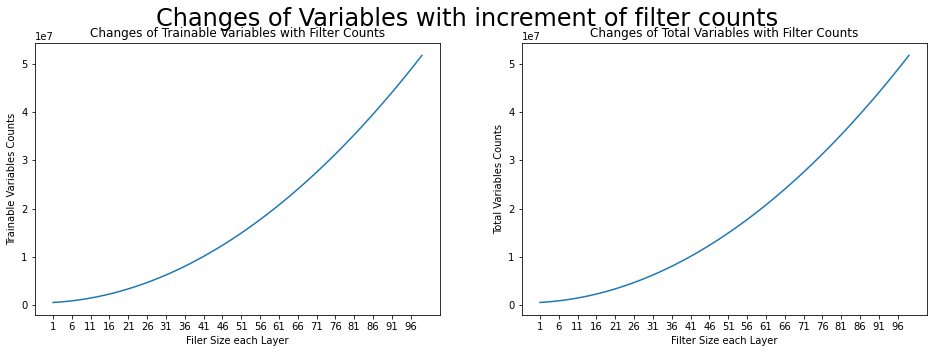

In [21]:
from tensorflow.keras import backend as K

def count(model):
    trainable_variables = 0
    total_variables = 0
    for variable in model.trainable_variables:
        variables = 1
        for dim in variable.get_shape():
            variables *= dim
        trainable_variables += variables
    for variable in model.variables:
        variables = 1
        for dim in variable.get_shape():
            variables *= dim
        total_variables += variables

    return trainable_variables, total_variables

trainable_variables = []
total_variables = []

maximum_filter_counts=100
for i in range(1,maximum_filter_counts):
    test_model=VGG19_Model(filter_of_first_layer=i)
    results=count(test_model)
    trainable_variables.append(results[0])
    total_variables.append(results[1])
    K.clear_session()

plt.rcParams['figure.figsize'] = (16.0, 5.0)
plt.subplot(121)
plt.plot(list(range(1, maximum_filter_counts)), trainable_variables)
plt.xticks(list(range(1, maximum_filter_counts, 5)))
plt.ylabel('Trainable Variables Counts')
plt.xlabel('Filer Size each Layer')
plt.title('Changes of Trainable Variables with Filter Counts')
plt.subplot(122)
plt.plot(list(range(1, maximum_filter_counts)), total_variables)
plt.xticks(list(range(1, maximum_filter_counts, 5)))
plt.ylabel('Total Variables Counts')
plt.xlabel('Filter Size each Layer')
plt.title('Changes of Total Variables with Filter Counts')
plt.suptitle('Changes of Variables with increment of filter counts',fontsize=24)

In [22]:
# plt.rcParams['figure.figsize'] = (8.0, 7.0)
# plt.plot(filter_of_first_layer,par)
# plt.ylabel('Number of total parameters')
# plt.xlabel('The number of filter of the first layer')
# plt.title('Changes of number of parameters with increase of Filter Count')

**Discoveries and Explanations**:

We have found that the amount of parameters just increases with the number of filters in each layer by creating multiple models with different layer counts, and it seems to have an **exponential relationship**.
And from our perspectives, the reason why the relationship appears to be exponential is that the amount of parameters within a layer not only has a relationship with its numbers of filters but also has a relationship with the output of the previous layer： when the previous layer has more filters, the dimension of the feature map it generates also has more dimension so that more parameters would be needed for that feature map. And the relationship passes from a layer to the next one, the number of parameters increases with the accumulation from the previous laye. So when we increase the number of filters all at once, the accumulation of dimension is analogous to the multiplicative calculation，so that the relationship is an exponential one.

### 1.2

**1.2 Choosing a Model, Training and Evaluating It. [20pts total]**


 **[15pts]** Take your model from above and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes.
 
 **[5pts]** Plot the loss and accuracy (both train and test) for your chosen architecture.

In [23]:
def load_dataset():
    (x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
    x_train,x_test = x_train.astype('float32'),x_test.astype('float32')
    x_train = x_train / 255
    x_test = x_test / 255
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    print(y_train.shape)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )
    train_generator = datagen.flow(x_train,y_train,batch_size=128,subset='training')
    validation_generator = datagen.flow(x_train,y_train,batch_size=128,subset='validation')
    return train_generator,validation_generator,x_train,y_train,x_test,y_test

EarlyStop = tf.keras.callbacks.EarlyStopping(patience=10)
train_generator,validation_generator,x_train,y_train,x_test,y_test = load_dataset()
history = VGG_Model.fit(train_generator,validation_data=validation_generator,verbose=1,epochs=100,callbacks=[EarlyStop])

(50000, 10)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 79 steps
Epoch 1/100
313/313 [==============================] - 46s 148ms/step - loss: 44.3131 - accuracy: 0.3114 - val_loss: 31.1428 - val_accuracy: 0.0937
Epoch 2/100
313/313 [==============================] - 32s 102ms/step - loss: 19.3037 - accuracy: 0.4882 - val_loss: 13.0443 - val_accuracy: 0.2713
Epoch 3/100
313/313 [==============================] - 32s 101ms/step - loss: 9.5480 - accuracy: 0.5664 - val_loss: 7.8249 - val_accuracy: 0.5275
Epoch 4/100
313/313 [==============================] - 32s 101ms/step - loss: 6.5821 - accuracy: 0.6145 - val_loss: 5.8356 - val_accuracy: 0.6033
Epoch 5/100
313/313 [==============================] - 32s 101ms/step - loss: 5.1607 - accuracy: 0.6534 - val_loss: 4.9306 - val_accuracy: 0.5912
Epoch 6/100
313/313 [==============================] - 32s 102ms/step - loss: 4.2918 - accuracy: 0.6850 - val_loss: 4.0288 - val_accuracy: 0.6608
Epoch 7/100
313

Text(0.5, 0.98, 'Model Loss and Accuracy(In Log form)')

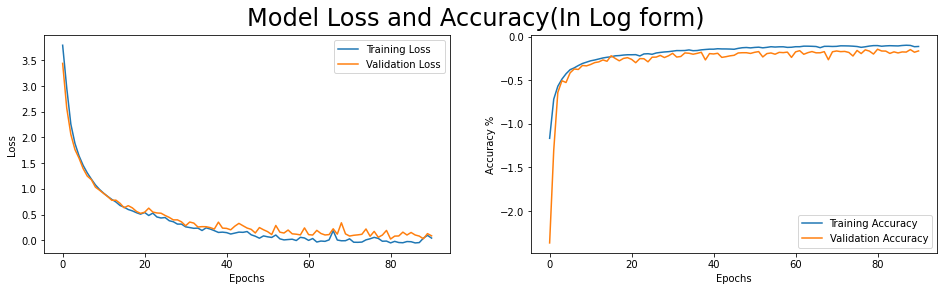

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(np.log(history.history['loss']), label='Training Loss')
ax[0].plot(np.log(history.history['val_loss']), label='Validation Loss')
ax[1].plot(np.log(history.history['accuracy']), label='Training Accuracy')
ax[1].plot(np.log(history.history['val_accuracy']),
           label='Validation Accuracy')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('Model Loss and Accuracy(In Log form)', fontsize=24)

In [25]:
evaluations=VGG_Model.evaluate(x_test,y_test)
print('Test accuracy: {}, test loss: {}'.format(evaluations[1],evaluations[0]))

10000/10000 [==============================] - 5s 510us/sample - loss: 1.1388 - accuracy: 0.8468
Test accuracy: 0.8468000292778015, test loss: 1.1387953268051147


### 1.3


**1.3 [14pts]** For a given input image from the test set that is correctly classified, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the feature maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_feature_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

**Helper code to generate feature maps**

In [26]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

**A dictionary to turn class index into class labels for CIFAR-10**

In [27]:
cifar10dict = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Text(0.5, 1.0, 'Randomly Chosen Image:airplane')

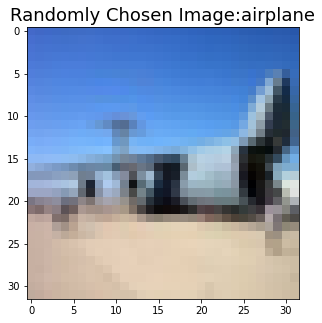

In [28]:
a=random.randint(0,x_test.shape[0])
image=x_test[a]
label=cifar10dict[int(np.argwhere(y_test[a]==1))]
plt.imshow(image)
plt.title('Randomly Chosen Image:{}'.format(label),fontsize=18)

[123, 49, 251, 246, 252, 137, 10, 232, 107]


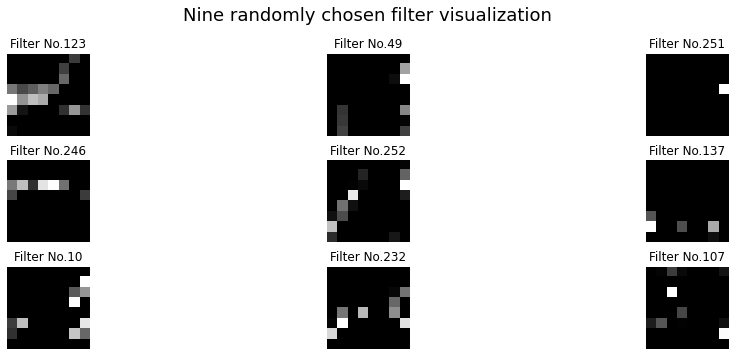

In [29]:
filters=get_feature_maps(VGG_Model,10,image)
filter_counts=filters.shape[0]
filter_chosen=[]
for i in range(0,9):
    filter_chosen.append(random.randint(0,filter_counts))
print(filter_chosen)

for i, filter_index in enumerate(filter_chosen):
    plt.subplot(330 + 1 + i)
    plt.imshow(filters[filter_index], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Filter No.{}'.format(filter_index))
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle('Nine randomly chosen filter visualization',fontsize=18)
plt.show()

 **1.4** [10pts] For the same input image generate and plot a (SmoothGrad) saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM heatmap. This is most easily done with the tf-keras-vis package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own colormap; the jet colormap is harder to interpret than sequential ones. Arrange the three plots in a row using subplots: Original Image, Saliency Map, GradCAM. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

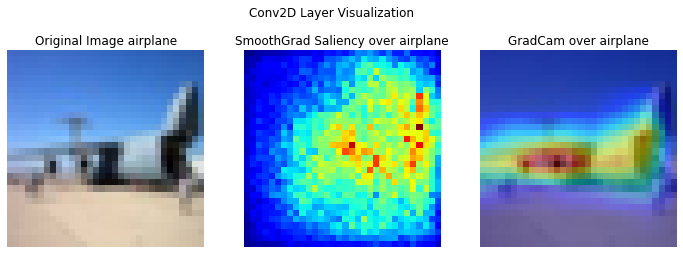

In [30]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()

saliency = Saliency(VGG_Model,
                    model_modifier=replace2linear,
                    clone=True)
score = CategoricalScore([int(np.argwhere(y_test[a]==1))])
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.


# Create Gradcam object
gradcam = Gradcam(VGG_Model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=15)
cam = normalize(cam)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].imshow(image)
ax[0].set_title('Original Image {}'.format(label))
ax[0].axis('off')
ax[1].imshow(saliency_map[0],cmap='jet')
ax[1].axis('off')
ax[1].set_title('SmoothGrad Saliency over {}'.format(label))
ax[2].imshow(image)
ax[2].axis('off')
ax[2].imshow(heatmap,cmap='jet', alpha=0.5)
ax[2].set_title('GradCam over {}'.format(label))

plt.subplots_adjust(top=0.85)
plt.suptitle('Conv2D Layer Visualization')
plt.show()

**Discoveries**:

SmoothGrad Saliency Map could promise a better representation of what the network is focusing on, while the GradCam heat map could be the same across the whole image with no color difference when in the rear part of the network.

It seems that the model is focusing on the objects themselves most of the time, and sometimes it also focuses on a part of that object, especially for some animals: the model grants great importance on the heads of animals. That does not mean the model does not pay attention to the surroundings, it also grants attention to surroundings, but with less importance.


  **1.5** [14pts] Repeat 1.4 for an image from the test set that is incorrectly classified, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the incorrect class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure? 

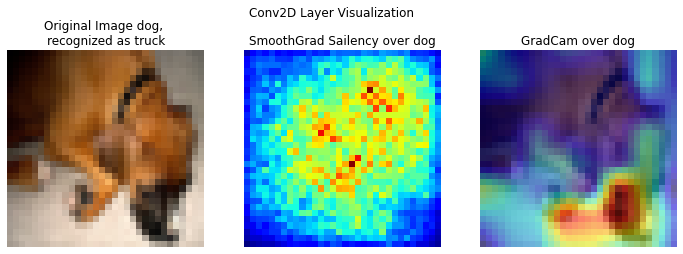

In [31]:
chosen_index=0
image=0
label=0
result=0
while True:
    chose_index=random.randint(0,x_test.shape[0])
    image=x_test[chose_index]
    image=image[np.newaxis,:]
    result=VGG_Model.predict(image)
    label=cifar10dict[int(np.argwhere(y_test[chose_index]==1))]
    result=cifar10dict[int(np.argmax(result))]
    if(label!=result):
        break
image=np.squeeze(image)

replace2linear = ReplaceToLinear()

saliency = Saliency(VGG_Model,
                    model_modifier=replace2linear,
                    clone=True)
score = CategoricalScore([int(np.argwhere(y_test[chosen_index]==1))])
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.


# Create Gradcam object
gradcam = Gradcam(VGG_Model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=15)
cam = normalize(cam)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].imshow(image)
ax[0].set_title('Original Image {}, \nrecognized as {}'.format(label,result))
ax[0].axis('off')
ax[1].imshow(saliency_map[0],cmap='jet')
ax[1].axis('off')
ax[1].set_title('SmoothGrad Sailency over {}'.format(label))
ax[2].imshow(image)
ax[2].axis('off')
ax[2].imshow(heatmap,cmap='jet', alpha=0.5)
ax[2].set_title('GradCam over {}'.format(label))

plt.subplots_adjust(top=0.85)
plt.suptitle('Conv2D Layer Visualization')
plt.show()


**Discoveries and Interpretations**:

For some incorrect examples, we found during the homework, the model does focus on the main objects in the pictures, but it fails to generate correct information.

For example, the model could not tell a picture between tag "cat" and tag "dog", even the model had already focused on the head part of that cat in the picture. This failure could result from the low resolution of the input images: the head of that cat only takes up few pixels, and even humans could not clearly judge whether that is a cat's head or dog's head.

Based on the interpretation, we thought the model should have a wider Receptive Field, to gain more information about the image within a larger area. Also, the input image could have a higher resolution. Images with ambiguous information, for example, similar cats and dogs, flying birds and planes, should be taken into the model for training in order to get higher accuracy when handling those tough tasks.

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Part 2: Regression with CNN [50 pts total] </h2>

## Problem Statement

In this problem we will construct a neural network to predict *how far a face is from being "upright"*. 

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf), where the authors trained a network to straighten a wide variety of images using the Microsoft COCO dataset. 

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this, we will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures. 

The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 
    
</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Questions </h2>

### Data preparation [20 points]

**2.1.1[10 points]** **Loading CelebA and Thinking about Datasets**.

Run the cells provided to automatically download the CelebA dataset. It is about 1.3GB, which can take 10-20 minutes to download. This happens only once; in the future when you rerun the cell, it will use the dataset stored on your google drive.

**NOTE**: If you get a `NonMatchingChecksumError`, note that this is a documented issue and is because of multiple server requests. Refer [here](https://github.com/tensorflow/datasets/issues/1482) for more details.

The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 

[TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from part 1 where the entire dataset was loaded in as an array. 

Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`). 

Explain in less than 150 words why using this approach is advantageous over loading the entire data in one array.

   
**2.1.2[5 points]** **Taking a look**.

In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. 

Hint: one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more.

**2.1.3[5 points]** **Conceptual Question**

Dropout layers have been shown to work well for regularizing deep neural networks, and can be used for very little computational cost. 

Write in **3-5 sentences** if it is a good idea to use dropout layers? 

Explain, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

### Building and training your CNN [25 points]

**2.2.1[5 points]** **Compiling your model**.

Construct a model with multiple Conv layers and any other layers you think would help. Be sure to output `<yourmodelname>.summary()` as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we were able to it with substantially fewer. Any working setup is acceptable though.

**2.2.2[10 points]** **Training your model**.

Train your model using `<yourmodelname>.fit()`. The syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. Your final model should be trained on all the available training data though. You should achieve a validation loss of less than 9, corresponding to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

**2.2.3[10 points]** **Evaluating your model**.

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like this:

This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

### Further Analysis [5 points]

**2.3.1[5 points]** **Correct an image of your choosing**.

Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.
    
</div>

**2.1.1** **Loading CelebA and Thinking about Datasets**.

Run the cells provided to automatically download and load the CelebA dataset. It is about 1.3GB, and may take some time to download. Please ensure you are running the `2.1.0` version of tensorflow.

The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 

[TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from part 1 where the entire dataset was loaded in as an array. 

Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`). 

In [32]:
#mount your own drive to avoid downloading the data multiple time 

# from google.colab import drive
# drive.mount('/content/gdrive')

In [33]:
#Following creates a directory, downloads the file and unzips it. 

if os.path.isdir('gdrive/My Drive/celeb_a/2.0.1'):
    print('Found dataset' )
else:
    os.makedirs('gdrive/My Drive/celeb_a')
    # !gdown -qq https://drive.google.com/u/2/uc?id=1CdfrT4f87b8ggx02TxsBuMTu0bqSIpNX&export=download
    # !unzip 2.0.1.zip  -d gdrive/My\ Drive/celeb_a/

Found dataset


In [34]:
# This command will use the celeb_a dataset that you downloaded, and load it into train and test 'tensorflow.Datasets'

train_celeb, test_celeb = tfds.load('celeb_a', split=['train', 'test'], shuffle_files=False, data_dir = 'gdrive/My Drive/', download=False)

In [35]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [36]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

**Explanation**:

When compared with loading whole datasets in one array into memory, the pipeline could save the use of memory since we could load a batch of images into the memory at once.

Also some api provided by tensorflow pipeline could promise better training performance. Training with prefetch could save more time when model training, since it could make full use CPU time when GPU is training the model. Also, api `map` could also use paralle strategy to increase the preprocess of data.

**2.1.2** **Taking a look**.

In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. 

Hint: one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more.

Text(0.5, 0.98, 'Four Image samples')

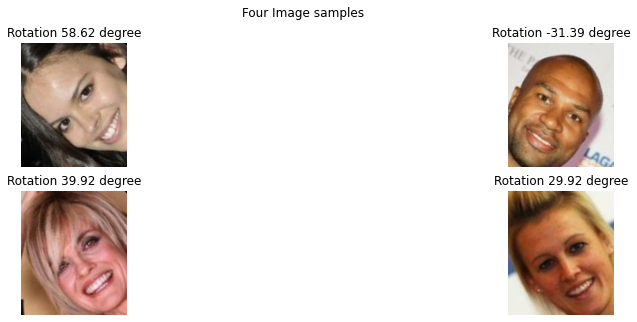

In [37]:
ir=iter(train_rot_ds)
i=0
while i<4:
  current=next(ir)
  plt.subplot(220 + 1 + i)
  plt.imshow(current[0])
  plt.axis('off')
  a=('%.2f' % current[1])
  plt.title('Rotation {} degree'.format(a))
  i=i+1
plt.suptitle('Four Image samples')

**2.1.3** **Conceptual Question**

Dropout layers have been shown to work well for regularizing deep neural networks, and can be used for very little computational cost. 

Write in **3-5 sentences** if it is a good idea to use dropout layers? 

Explain, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

**Explanation**:

Dropout means to stop updating some weights within the network with a given rate to avoid the model overfitting.

In our model, it would be good for us to deploy Dropout in the dense layers since so many parameters are contained in those dense layers.

But it would be a wiser choice to not use Dropout in the Convolution years. Since the filters have already reduced the number of parameters, and those parameters may have great influence over the feature extraction. Also, some replacements, like global average pooling and Batch Normalization, could be used to avoid overfitting instead of Dropout in the Convolution layers.

**2.2.1** **Compiling your model**.

Construct a model with multiple Conv layers and any other layers you think would help. Be sure to output `<yourmodelname>.summary()` as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we were able to it with substantially fewer. Any working setup is acceptable though.

In [38]:
def construct_block(model, kernel_size, filters, layer_counts):
    for i in range(0, layer_counts):
        model.add(tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [39]:
def build_easy_model(rebuild=False):
    model = tf.keras.Sequential(name='EasyVGG')
    model.add(tf.keras.layers.Input(shape=(140, 120, 3)))

    construct_block(model,(3,3),8,2)
    construct_block(model,(3,3),16,2)
    construct_block(model,(3,3),32,2)
    construct_block(model,(3,3),64,2)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.25))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.25))
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    if not rebuild:
        model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,
                                                    decay=1e-06),
              loss='mse')
    return model

**2.2.2** **Training your model**.

Train your model using `<yourmodelname>.fit()`. The syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. Your final model should be trained on all the available training data though. You should achieve a validation loss of less than 9, corresponding to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

In [40]:
train_rot_ds_batch = train_rot_ds.batch(64)
train_rot_ds_batch = train_rot_ds_batch.prefetch(tf.data.experimental.AUTOTUNE)

test_rot_ds_batch = test_rot_ds.batch(64)
test_rot_ds = test_rot_ds_batch.prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
class EarlyStoppingAtCurrent(tf.keras.callbacks.Callback):

    def __init__(self):
        super(EarlyStoppingAtCurrent, self).__init__()
        self.epoch=0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        self.epoch+=1
        if current < 9:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        print("Epoch %05d: early stopping" % (self.epoch))

In [42]:
model=build_easy_model()
model.fit(train_rot_ds_batch,
    epochs=20,
    validation_data=test_rot_ds_batch,
    callbacks=[EarlyStoppingAtCurrent()])

Model: "EasyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 140, 120, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 140, 120, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 120, 8)       584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 120, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 60, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 60, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 60, 16)        64  

In [43]:
difference=0
counts=0
for i in iter(test_rot_ds):
    result=model.predict(i[0])
    j=i[1].numpy()
    j.reshape(-1,1)
    test=np.squeeze(result,1)
    difference+=np.sum(np.abs(test-j))
    counts+=64
eva=difference/counts
print("Average Differnece: %05f Degree" % (eva))

Average Differnece: 1.870742 Degree


**2.2.3** **Evaluating your model**.

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like this:

This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

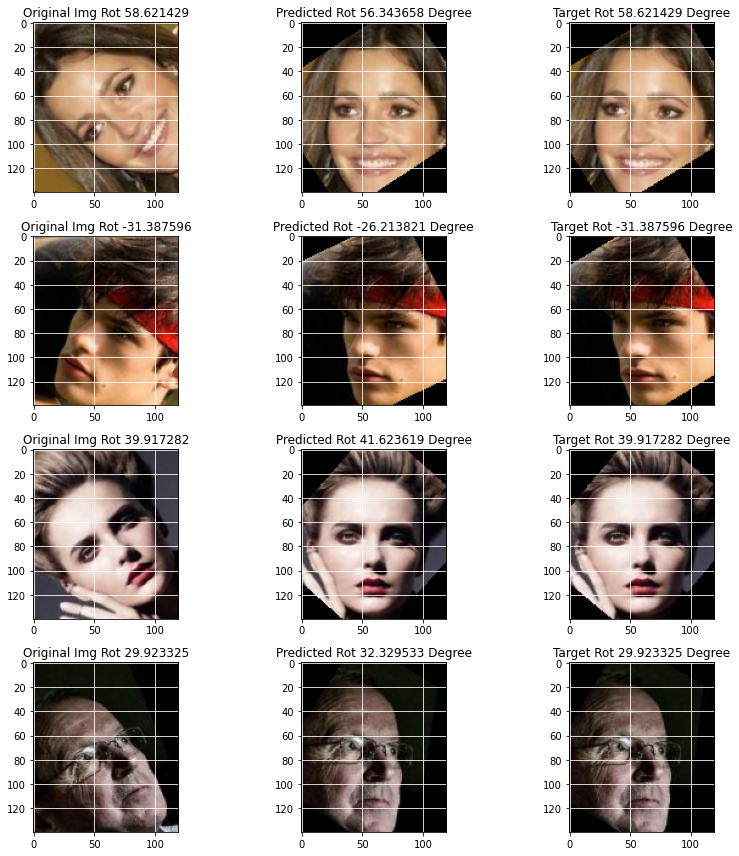

In [44]:
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)
itr=iter(test_rot_ds)
chosen_iters=[]
images=[]
rotations=[]
for i in range(4):
    chosen_iters.append(random.randint(0,2000))
for i in chosen_iters:
    j=0
    temp=0
    if j !=i:
        temp=next(itr)
    images.append(temp[0])
    rotations.append(temp[1])

f, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
for i in range(4):
    ax[i][0].imshow(images[i])
    ax[i][0].set_title("Original Img Rot %3f" % (rotations[i]))
    pred=model.predict(images[i][np.newaxis,:])
    ax[i][1].imshow(rot_resize(images[i],-float(pred)))
    ax[i][1].set_title('Predicted Rot %3f Degree' % (float(pred)))
    ax[i][2].imshow(rot_resize(images[i],-rotations[i]))
    ax[i][2].set_title('Target Rot %3f Degree'% (rotations[i]))
    ax[i][0].grid(alpha=1,color='white')
    ax[i][1].grid(alpha=1,color='white')
    ax[i][2].grid(alpha=1,color='white')
    
f.tight_layout()

**2.3.1** **Correct an image of your choosing**.

Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

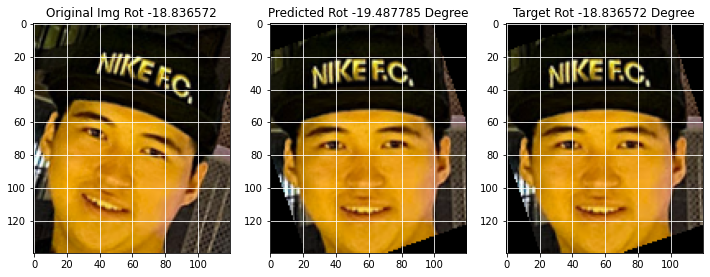

In [46]:
from skimage import io

image_path='https://gitee.com/TomGoh/img/raw/master/test1.png'
image = io.imread(image_path)
image=np.array(image)

deg=random.uniform(-60,60)
rotimg = ndimage.rotate(image,deg, reshape=False, order=3)

rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
nor_rotimg=normalize_image(rotimg)
result=model.predict(nor_rotimg[np.newaxis,:])

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
ax[0].imshow(rotimg)
ax[0].set_title("Original Img Rot %3f" % (deg))
ax[1].imshow(rot_resize(nor_rotimg,-float(result)))
ax[1].set_title('Predicted Rot %3f Degree' % result)
ax[2].imshow(rot_resize(nor_rotimg,-deg))
ax[2].set_title('Target Rot %3f Degree'% (deg))
ax[0].grid(alpha=1,color='white')
ax[1].grid(alpha=1,color='white')
ax[2].grid(alpha=1,color='white')